<a href="https://colab.research.google.com/github/003Palkush/Data-Analysis-Project/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries

In [13]:
!pip install catboost


In [14]:

import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


from imblearn.over_sampling import SMOTE


from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier


from sklearn.metrics import accuracy_score, roc_auc_score, classification_report


import matplotlib.pyplot as plt
import seaborn as sns



Load Data

In [15]:
# Load the datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')
column_desc = pd.read_csv('column description.csv')

print("Train dataset shape:", train.shape)
print("Test dataset shape:", test.shape)
train.head()


Train dataset shape: (215258, 122)
Test dataset shape: (92253, 121)


,ID,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,196348,0,Cash loans,F,N,Y,2,225000.0,785398.5,33403.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
1,147976,0,Cash loans,M,N,Y,0,90000.0,592560.0,35937.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,52662,0,Revolving loans,F,N,Y,1,126000.0,202500.0,10125.0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,4.0
3,101577,0,Cash loans,F,N,Y,0,157500.0,254700.0,18531.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,173078,0,Cash loans,F,Y,N,0,540000.0,1252363.5,47830.5,...,0,0,0,0,0.0,0.0,1.0,0.0,0.0,5.0


Handle Missing Values

Missing values in train dataset:
 COMMONAREA_MODE             150500
COMMONAREA_AVG              150500
COMMONAREA_MEDI             150500
NONLIVINGAPARTMENTS_MODE    149455
NONLIVINGAPARTMENTS_AVG     149455
                             ...  
NAME_HOUSING_TYPE                0
NAME_FAMILY_STATUS               0
NAME_EDUCATION_TYPE              0
NAME_INCOME_TYPE                 0
ID                               0
Length: 122, dtype: int64


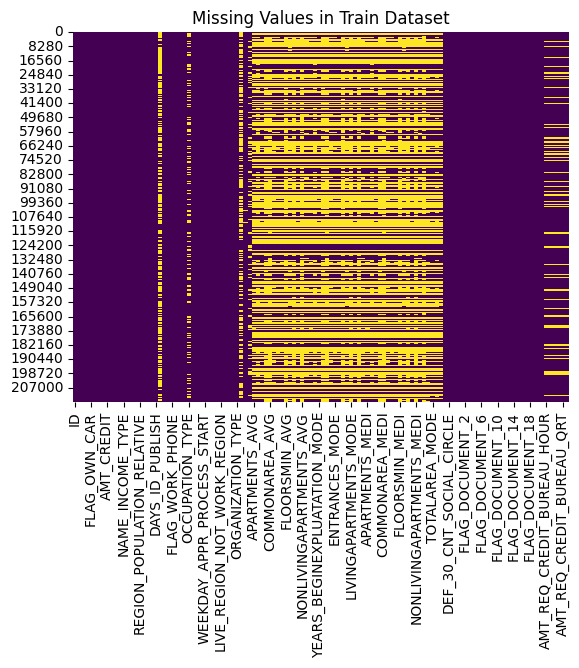

In [16]:
# Check missing values
missing_values = train.isnull().sum().sort_values(ascending=False)
print("Missing values in train dataset:\n", missing_values)


sns.heatmap(train.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values in Train Dataset")
plt.show()


In [17]:
target = 'TARGET'  # Replace this with the actual target column name
X = train.drop(columns=[target])
y = train[target]

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [18]:
# Separate numerical and categorical columns
num_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
cat_cols = X_train.select_dtypes(include=['object']).columns

# Impute missing values
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

# Apply imputations
X_train[num_cols] = num_imputer.fit_transform(X_train[num_cols])
X_train[cat_cols] = cat_imputer.fit_transform(X_train[cat_cols])
X_val[num_cols] = num_imputer.transform(X_val[num_cols])
X_val[cat_cols] = cat_imputer.transform(X_val[cat_cols])

Data Preprocessing

In [19]:
label_encoders = {}
for col in cat_cols:
    label_encoders[col] = LabelEncoder()
    X_train[col] = label_encoders[col].fit_transform(X_train[col])
    X_val[col] = label_encoders[col].transform(X_val[col])

In [20]:
# Scale numerical features
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols] = scaler.transform(X_val[num_cols])




In [21]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
print("Class distribution after SMOTE:\n", pd.Series(y_train).value_counts())



Class distribution after SMOTE:
 TARGET
1    158304
0    158304
Name: count, dtype: int64


In [22]:
# Initialize the model
model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)[:, 1]


In [23]:
# XGBoost Model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
xgb_preds = xgb_model.predict(X_val)
xgb_preds_proba = xgb_model.predict_proba(X_val)[:, 1]

# Evaluate the model
print("XGBoost Accuracy:", accuracy_score(y_val, xgb_preds))
print("XGBoost ROC-AUC:", roc_auc_score(y_val, xgb_preds_proba))


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:28:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.9168679736133049
XGBoost ROC-AUC: 0.715084186101095


In [26]:
# LightGBM Model
lgb_model = lgb.LGBMClassifier(
    objective='binary',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=-1,
    random_state=42
)

# Train the model
lgb_model.fit(X_train, y_train)

# Make predictions
lgb_preds = lgb_model.predict(X_val)
lgb_preds_proba = lgb_model.predict_proba(X_val)[:, 1]

# Evaluate the model
print("LightGBM Accuracy:", accuracy_score(y_val, lgb_preds))
print("LightGBM ROC-AUC:", roc_auc_score(y_val, lgb_preds_proba))


[LightGBM] [Info] Number of positive: 158304, number of negative: 158304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.351897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21389
[LightGBM] [Info] Number of data points in the train set: 316608, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM Accuracy: 0.9179364489454613
LightGBM ROC-AUC: 0.7317576087889511


In [25]:
# CatBoost Model
cat_model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    random_state=42,
    verbose=0  # Suppress verbose output
)

# Train the model
cat_model.fit(X_train, y_train)

# Make predictions
cat_preds = cat_model.predict(X_val)
cat_preds_proba = cat_model.predict_proba(X_val)[:, 1]

# Evaluate the model
print("CatBoost Accuracy:", accuracy_score(y_val, cat_preds))
print("CatBoost ROC-AUC:", roc_auc_score(y_val, cat_preds_proba))


CatBoost Accuracy: 0.9184706866115395
CatBoost ROC-AUC: 0.7291901826216352


Accuracy: 0.9136625476168354
ROC-AUC: 0.6789266570875678
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95     39576
           1       0.21      0.02      0.04      3476

    accuracy                           0.91     43052
   macro avg       0.56      0.51      0.50     43052
weighted avg       0.86      0.91      0.88     43052



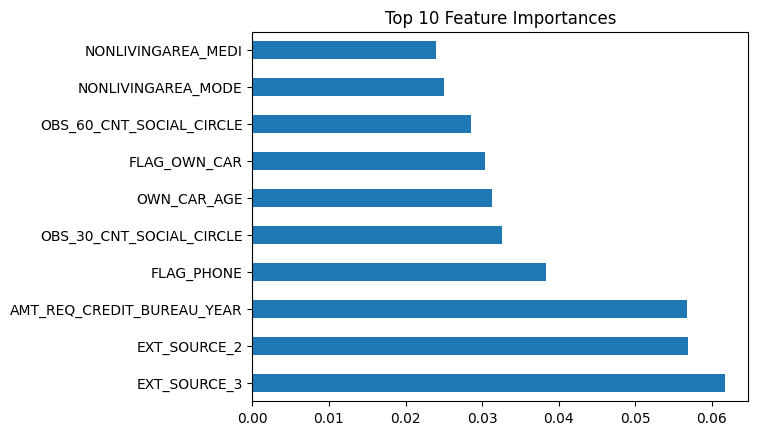

In [24]:
# Evaluate accuracy
print("Accuracy:", accuracy_score(y_val, y_pred))

# Evaluate ROC-AUC
print("ROC-AUC:", roc_auc_score(y_val, y_pred_proba))

# Classification report
print("Classification Report:\n", classification_report(y_val, y_pred))

feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feature_importances.nlargest(10).plot(kind='barh', title='Top 10 Feature Importances')
plt.show()


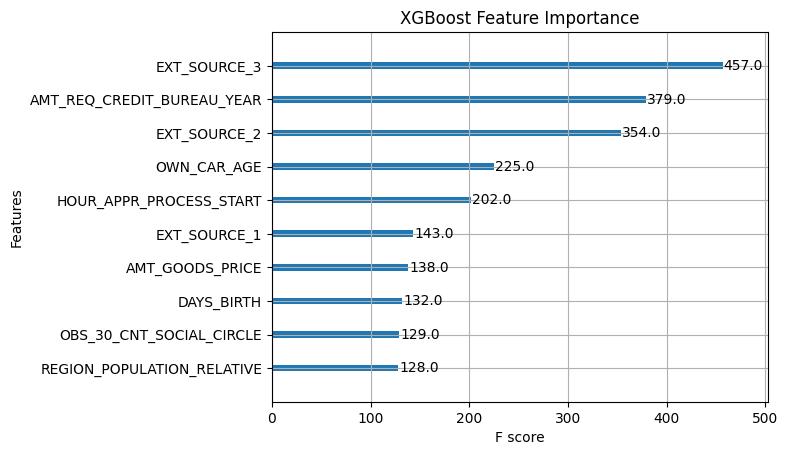

In [27]:
xgb.plot_importance(xgb_model, max_num_features=10, importance_type='weight')
plt.title("XGBoost Feature Importance")
plt.show()


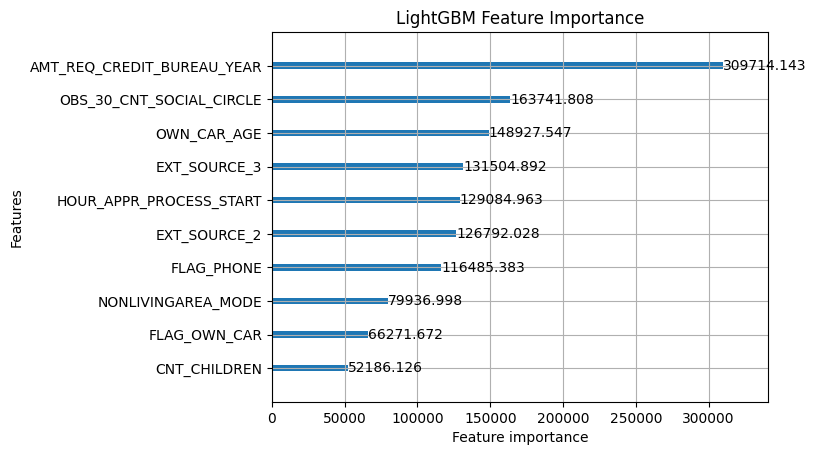

In [28]:
lgb.plot_importance(lgb_model, max_num_features=10, importance_type='gain')
plt.title("LightGBM Feature Importance")
plt.show()


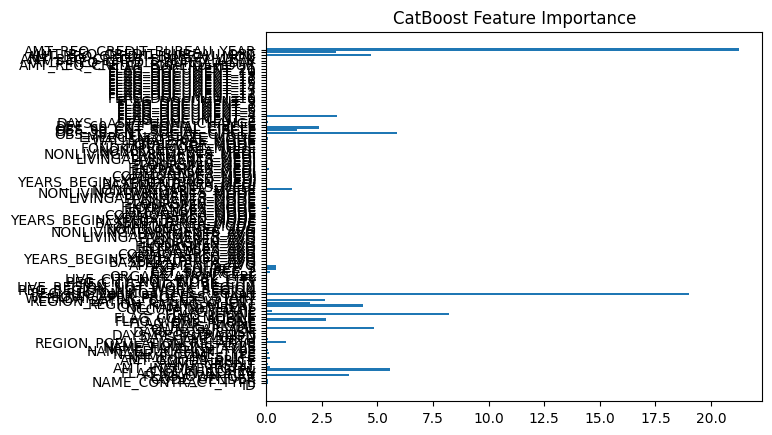

In [29]:
cat_feature_importances = cat_model.get_feature_importance()
plt.barh(X_train.columns, cat_feature_importances)
plt.title("CatBoost Feature Importance")
plt.show()
